In [1]:
import alias
import alias.injection as inj
import alias.continuum_normalization as cn

import matplotlib.pyplot as plt
import scipy.signal

import numpy as np
from astropy.io import fits

import random as rand

import tqdm.autonotebook as tqdm

plt.rcParams.update({'font.size': 10})

%matplotlib inline

/mnt_home/jhand/alias/alias/injection.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
with open('../data/sample_star_urls', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

/mnt_home/jhand/alias/alias/__init__.py:57: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2


In [3]:
# Injection Testing Framework

def create_laser_signature(wave, lsf, idx):
    line = np.interp(np.array(range(len(wave)))-idx, lsf.x, lsf.y)
    return line

def injection_test(ds, lsf, detector, count, min_amp, max_amp):
    results = []

    for i in tqdm.trange(count):
        
        spec = rand.randrange(len(ds.flux))
        valid_idx = np.nonzero(~np.isnan(ds.flux[spec]))[0]
        idx_int = np.random.choice(valid_idx)
        idx = idx_int + np.random.uniform(-0.5, 0.5)
        wave = np.interp(idx, range(len(ds.wave)), ds.wave)
        amp = np.random.uniform(min_amp, max_amp)

        nflux = np.copy(ds.flux[spec])
        nflux += create_laser_signature(ds.wave, lsf, idx)*amp
        
        detections = detector(ds.wave, nflux, ds.ivar[spec])

        if len(detections) == 0:
            results.append((spec, idx, amp, 0, 0, 0, 0))
            continue

        detection_wavelengths = detections[:,0]
        detection_amplitudes = detections[:,1]

        detec_id = np.argmin(np.abs(detection_wavelengths - wave))
        delta_wave = detection_wavelengths[detec_id] - wave

        if np.abs(delta_wave) > 1:
            results.append((spec, idx, amp, 0, 0, 0, len(detections)))
            continue
        
        delta_flux = detection_amplitudes[detec_id] - amp
        results.append((spec, idx, amp, 1, delta_wave, delta_flux, len(detections) - 1))

    return np.array(results, dtype=float)

In [4]:
def chi2_lsf(y, y_err, lsfx, lsfy, amp, center_pix):
    lsf = np.interp(range(len(y)), lsfx + center_pix, amp*lsfy)
    return np.sum(((y - lsf)/y_err)**2)

def improve_properties(wave, flux, ivar, amp):
    center_idx = np.linspace(len(wave)/2 - 1, len(wave)/2, 64)
    
    chi2 = [ chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), 0.3, center) for center in center_idx ]
    
    best_idx = center_idx[np.argmin(chi2)]
    best_wl = np.interp(best_idx, range(len(wave)), wave)

    # We can use our approximate guess of the amplitude to get a range to look for an improved amplitude
    amps = np.linspace(amp * 0.7, amp*1.4, 64)
    
    chi2 = [ chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, best_idx) for amp in amps ]
    
    best_amplitude = amps[np.argmin(chi2)]

    return best_wl, best_amplitude

In [5]:
def accurate_detector(wave, flux, ivar):
        
    flux_norm_res, ivar_norm_res, _ = cn.continuum_normalize((flux, ), (ivar))
    flux_norm_res = flux_norm_res[0]
    ivar_norm_res = ivar_norm_res[0]
    flux_norm_res -= median_flux
    peaks = scipy.signal.find_peaks(flux_norm_res, height = 0.05)[0]

    amplitudes = flux_norm_res[peaks]
    
    amplitudes_corrected = []
    wavelengths = []

    for peak in peaks:
        peak_w = wave[peak-10:peak+11]
        peak_f = flux_norm_res[peak-10:peak+11]
        peak_i = ivar_norm_res[peak-10:peak+11]
        nan_filter = np.isnan(peak_f) | np.isnan(peak_w) | np.isnan(peak_i)
        wl, amp = improve_properties(peak_w[~nan_filter], peak_f[~nan_filter], peak_i[~nan_filter], flux_norm_res[peak])
        wavelengths.append(wl)
        amplitudes_corrected.append(amp)
    
    return np.array((wavelengths, amplitudes_corrected)).T

In [7]:
norm_flux = cn.continuum_normalize(ds.flux, ds.ivar)[0]

median_flux = np.nanmedian(norm_flux, axis=0)

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [8]:
all_detections = []

for i in tqdm.trange(len(ds.flux)):
        
        detections = accurate_detector(ds.wave, ds.flux[i], ds.ivar[i])

        for d in detections:
            all_detections.append((i, d[0], d[1]))

print(all_detections)

  0%|          | 0/1254 [00:00<?, ?it/s]

[(0, 15187.944449105747, 0.05471324331479103), (0, 15241.33468977443, 0.07743467808707706), (0, 15241.75582923332, 0.1779265452477921), (0, 15242.808728791673, 0.042536318613278064), (0, 15288.57471607472, 0.09167371967036404), (0, 15332.571549830041, 0.07797501956930654), (0, 15332.995210291383, 0.2546804620581586), (0, 15333.418882459026, 0.15806919712409095), (0, 15395.826207526821, 0.04960721027173552), (0, 15396.038910195632, 0.06128252073986583), (0, 15432.667524414177, 0.08482812332704359), (0, 15433.307168212952, 0.07527158099981376), (0, 15655.790459975651, 0.13948685905172584), (0, 15862.622902905343, 0.07737698036540494), (0, 15973.351464310743, 0.08703817294539688), (0, 16031.587281550917, 0.345944987670441), (0, 16080.518485053848, 0.08291508881435686), (0, 16129.354976341492, 0.24176532229975467), (0, 16195.41020085162, 0.10737943758384429), (0, 16235.774099046657, 0.19002976198956648), (0, 16236.222716261484, 0.39602516941799765), (0, 16351.477458950329, 0.06038579284079

In [14]:
all_detections = np.array(all_detections)

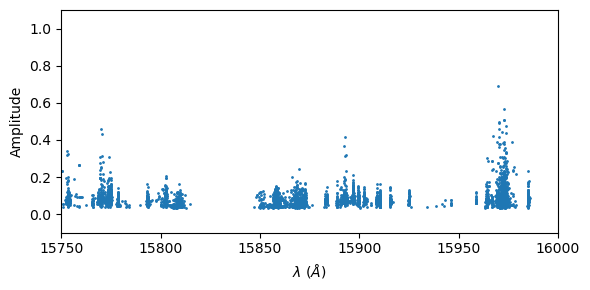

In [15]:
fig, ax = plt.subplots()

ax.scatter(all_detections[:,1], all_detections[:,2], s=1)

ax.set_xlim(15750, 16000)
ax.set_ylim(-0.1, 1.1)

ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Amplitude')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

plt.show()

In [16]:
wl_idx_detections = np.array(np.interp(all_detections[:,1], ds.wave, range(len(ds.wave))), dtype=int)

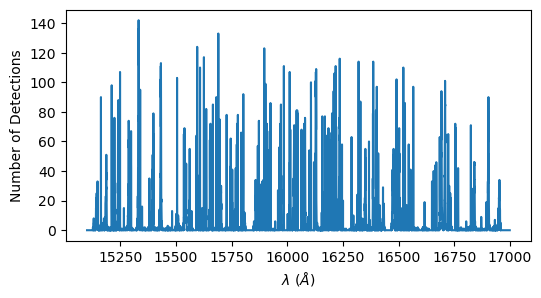

In [17]:
hist = np.array([0]*len(ds.wave))

hist_partial = np.bincount(wl_idx_detections)

hist[0:len(hist_partial)] = hist_partial

plt.figure(figsize=(6,3))

plt.plot(ds.wave, hist)

plt.xlabel(r'$\lambda$ ($\AA$)')
_ = plt.ylabel('Number of Detections')

In [18]:
mask = hist > 1
print(sum(mask) * 100/len(ds.wave))

27.97667638483965


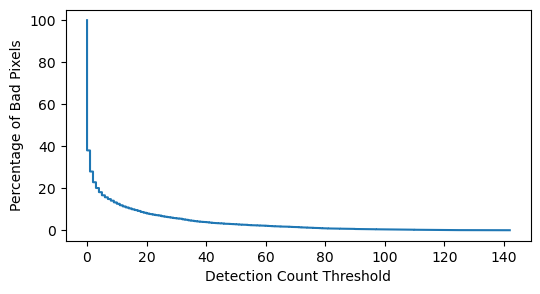

In [19]:

plt.figure(figsize=(6,3))

plt.plot(np.sort(hist), np.linspace(100, 0, len(hist)))

plt.xlabel('Detection Count Threshold')
_ = plt.ylabel('Percentage of Bad Pixels')

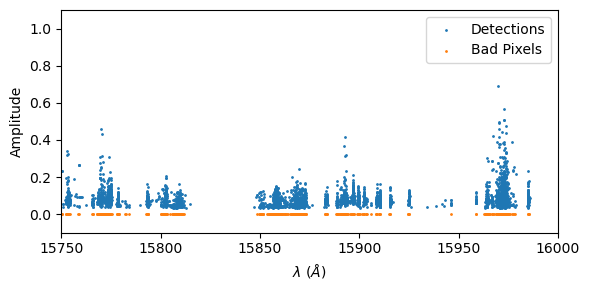

In [20]:
fig, ax = plt.subplots()

ax.scatter(all_detections[:,1], all_detections[:,2], s=1, label='Detections')
ax.scatter(ds.wave[mask], [0] * sum(mask), s=1, label='Bad Pixels')

ax.set_xlim(15750, 16000)
ax.set_ylim(-0.1, 1.1)

ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Amplitude')

ax.legend()

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

plt.show()

In [134]:
candidates = np.array(all_detections[~mask[wl_idx_detections]])
print(np.shape(candidates))

candidates[0,0]

with open('candidates.csv', 'w') as f:
    f.write('SPECTRUM_ID,WAVELENGTH,AMPLITUDE\n')
    [f.write(','.join(np.array(candidate, dtype=str)) + '\n') for candidate in candidates]

(862, 3)


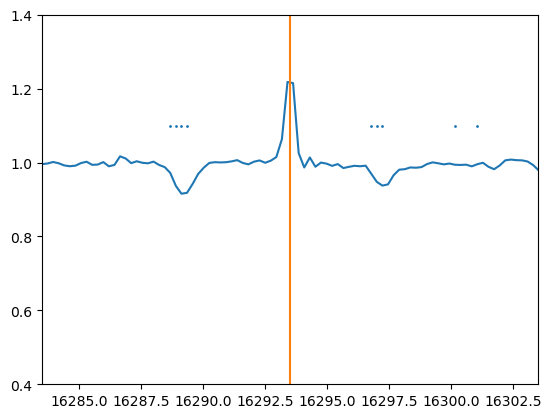

In [27]:
n = 35

plt.plot(ds.wave, norm_flux[int(candidates[n,0])])
plt.plot((candidates[n,1], candidates[n,1]), (0,2))

plt.xlim(candidates[n,1] - 10, candidates[n,1] + 10)
plt.ylim(0.4, 1.4)

plt.scatter(ds.wave[mask], [1.1]*sum(mask), s=1)

In [119]:
def get_width(wl, height, wave, residuals):
    wave_idx = int(np.interp(wl, wave, range(len(wave))))

    min = wave_idx-1
    while residuals[min] > height/2:
        min = min-1
    wl_l = np.interp(height/2, residuals[min:min+2], wave[min:min+2])
    
    max = wave_idx+1
    while residuals[max] > height/2:
        max = max+1
    wl_h = np.interp(height/2, np.flip(residuals[max-1:max+1]), np.flip(wave[max-1:max+1]))

    return wl_l,wl_h,wl_h-wl_l

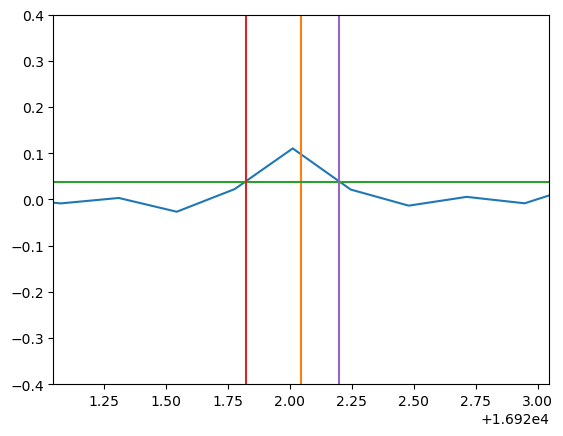

In [120]:
n = 37

wl_l,wl_h,_ = get_width(candidates[n,1], candidates[n,2], ds.wave, norm_flux[int(candidates[n,0])]-median_flux)

plt.plot(ds.wave, norm_flux[int(candidates[n,0])] - median_flux)
plt.plot((candidates[n,1], candidates[n,1]), (-2,2))

plt.xlim(candidates[n,1] - 1, candidates[n,1] + 1)
plt.ylim(-0.4, 0.4)

plt.plot((14000, 19000), (candidates[n,2]/2, candidates[n,2]/2))

plt.plot((wl_l, wl_l), (-2,2))
plt.plot((wl_h, wl_h), (-2,2))

plt.scatter(ds.wave[mask], [1.1]*sum(mask), s=1)

In [121]:
widths = np.array([ get_width(candidate[1], candidate[2], ds.wave, norm_flux[int(candidate[0])]-median_flux)[2] for candidate in candidates ])

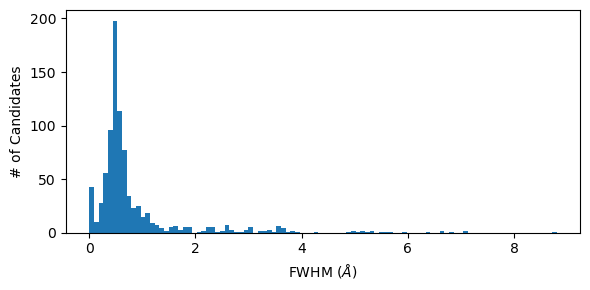

In [122]:
fig, ax = plt.subplots()

ax.hist(widths, bins=100)

ax.set_xlabel(r'FWHM ($\AA$)')
ax.set_ylabel(r'# of Candidates')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

plt.show()

In [124]:
np.argwhere(widths > 4)

array([[112],
       [113],
       [319],
       [320],
       [321],
       [329],
       [330],
       [470],
       [518],
       [519],
       [520],
       [529],
       [530],
       [533],
       [534],
       [535],
       [536],
       [760],
       [761],
       [764],
       [765]])

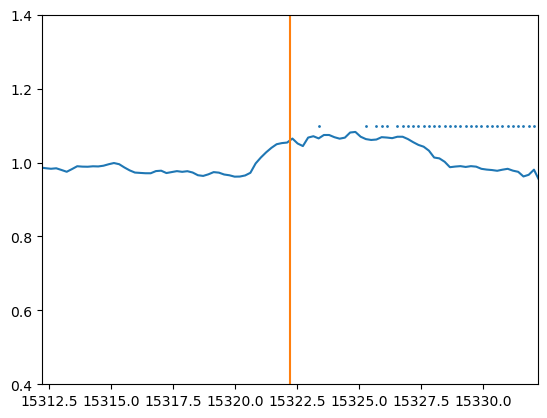

In [127]:
n = 319

plt.plot(ds.wave, norm_flux[int(candidates[n,0])])
plt.plot((candidates[n,1], candidates[n,1]), (0,2))

plt.xlim(candidates[n,1] - 10, candidates[n,1] + 10)
plt.ylim(0.4, 1.4)

plt.scatter(ds.wave[mask], [1.1]*sum(mask), s=1)